### - Exercici 1

Agafa el conjunt de dades que vulguis i realitza un pipeline i un gridsearch aplicant l'algorisme de Random Forest.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, label_binarize

In [2]:
wvb = pd.read_csv('wVb.csv')
wvb.head()

,index,name,date_of_birth,height,weight,spike,block,position_number,country
0,0,Angelina Lazarenko,13/04/1998,193,80,320,305,3,23
1,1,Svetlana Serbina,15/05/1996,182,71,295,284,1,23
2,2,Ekaterina Shkurikhina,17/06/1996,190,72,306,296,2,23
3,3,Kristina Kurnosova,17/06/1997,176,62,288,278,6,23
4,4,Ekaterina Novikova,07/12/1996,181,70,290,275,1,23


In [3]:
#Check for duplicates
wvb.duplicated(keep = 'first').sum()

0

In [4]:
#Check for nan values
wvb.isna().sum()

index              0
name               0
date_of_birth      0
height             0
weight             0
spike              0
block              0
position_number    0
country            0
dtype: int64

In [5]:
#After these fast checks, let's drop the columns we are not interested in
wvb.drop(['index', 'date_of_birth', 'country', 'name'], axis = 1, inplace = True)

In [6]:
wvb.head()

,height,weight,spike,block,position_number
0,193,80,320,305,3
1,182,71,295,284,1
2,190,72,306,296,2
3,176,62,288,278,6
4,181,70,290,275,1


In [7]:
#To better visualize the positions, let's turn them into labels, rather than numbers
conditions = [wvb['position_number'] == 1,
             wvb['position_number'] == 2,
             wvb['position_number'] == 3,
             wvb['position_number'] == 4,
             wvb['position_number'] == 6]

newValues = ['setter', 'wing', 'middle', 'opposite', 'libero']

wvb['position'] = np.select(conditions, newValues)
wvb.head()

,height,weight,spike,block,position_number,position
0,193,80,320,305,3,middle
1,182,71,295,284,1,setter
2,190,72,306,296,2,wing
3,176,62,288,278,6,libero
4,181,70,290,275,1,setter


In [8]:
#Finally drop the position_number column
wvb.drop('position_number', axis = 1, inplace = True)
wvb.head()

,height,weight,spike,block,position
0,193,80,320,305,middle
1,182,71,295,284,setter
2,190,72,306,296,wing
3,176,62,288,278,libero
4,181,70,290,275,setter


In [9]:
wvb.describe()

,height,weight,spike,block
count,432.000000,432.000000,432.000000,432.000000
mean,180.979167,68.743056,286.784722,275.506944
std,8.214753,7.344439,35.015972,33.246181
min,153.000000,52.000000,0.000000,0.000000
25%,175.750000,63.750000,285.000000,273.500000
50%,182.000000,69.500000,293.500000,283.000000
75%,187.000000,73.000000,304.000000,292.000000
max,199.000000,87.000000,336.000000,310.000000


We can see that our minimum value for the spike and block is 0, which is an extreme outlier given a mean of 280 approximately. Let's further dig in and see if it is libero related, since liberos do not spike nor block.

In [10]:
for c in wvb['position'].unique():
    
    print(f'Class {c}')
    print(wvb[wvb['position'] == c].describe())   

Class middle
           height      weight       spike       block
count  108.000000  108.000000  108.000000  108.000000
mean   186.888889   71.694444  297.000000  285.333333
std      5.229916    7.347780   11.766418   14.079215
min    176.000000   60.000000  270.000000  246.000000
25%    184.000000   66.750000  290.000000  279.750000
50%    186.000000   70.000000  295.500000  285.000000
75%    190.500000   76.500000  305.000000  297.000000
max    199.000000   87.000000  320.000000  305.000000
Class setter
           height     weight       spike       block
count   75.000000  75.000000   75.000000   75.000000
mean   176.880000  67.840000  285.840000  274.440000
std      6.859517   5.122921   21.653313   20.749627
min    153.000000  55.000000  200.000000  210.000000
25%    174.000000  65.000000  280.000000  272.000000
50%    180.000000  69.000000  287.000000  280.000000
75%    182.000000  71.000000  297.000000  284.000000
max    184.000000  75.000000  320.000000  310.000000
Class wing


We find out that it is not a class related issue, but rather missing data. Also, in classes other than libero (which do not spike or block), we find minimum block and spike values below the net heigth (224cm). These values are probably wrong, but we cannot prove it, so we are going to leave them be and hope for the best.  

In [11]:
#get the index of the problematic entries
indexToDrop = wvb.index[(wvb['spike'] == 0) | (wvb['block'] == 0)].tolist()
wvb.drop(index = indexToDrop, inplace = True)
wvb.describe()

,height,weight,spike,block
count,429.000000,429.000000,429.00000,429.000000
mean,181.000000,68.727273,288.79021,277.433566
std,8.239692,7.367695,25.57722,24.027017
min,153.000000,52.000000,178.00000,178.000000
25%,175.000000,63.000000,285.00000,274.000000
50%,182.000000,69.000000,294.00000,283.000000
75%,187.000000,73.000000,304.00000,292.000000
max,199.000000,87.000000,336.00000,310.000000


Next, dividing into train and test sets

In [12]:
# A stratified split is in order
xTrain, xTest, yTrain, yTest = train_test_split(wvb.iloc[:,:-1], wvb.iloc[:,-1],
                                                train_size = 0.7,shuffle = True,
                                                stratify = wvb.iloc[:,-1],
                                                random_state = 1)
#Also, reset the indexes for comodity
xTrain.reset_index(drop = True, inplace = True)
xTest.reset_index(drop = True, inplace = True)
yTrain.reset_index(drop = True, inplace = True)
yTest.reset_index(drop = True, inplace = True)

In [13]:
# Stats for the training and test subsets to see if we missed something
xTrain.describe()

,height,weight,spike,block
count,300.000000,300.000000,300.000000,300.000000
mean,181.316667,68.823333,289.650000,278.223333
std,8.171841,7.131267,24.131208,23.246824
min,153.000000,52.000000,188.000000,178.000000
25%,176.000000,64.000000,285.000000,275.000000
50%,183.000000,69.500000,295.000000,284.000000
75%,187.000000,73.000000,304.000000,293.000000
max,199.000000,87.000000,336.000000,310.000000


In [14]:
xTest.describe()

,height,weight,spike,block
count,129.000000,129.000000,129.000000,129.000000
mean,180.263566,68.503876,286.790698,275.596899
std,8.381079,7.914705,28.660915,25.750764
min,160.000000,52.000000,178.000000,178.000000
25%,175.000000,63.000000,285.000000,272.000000
50%,181.000000,69.000000,292.000000,282.000000
75%,186.000000,73.000000,304.000000,289.000000
max,199.000000,87.000000,336.000000,308.000000


We have our dataset finally clean and we are ready to start the actual preprocessing. First, check for class balance in the train subset.

In [15]:
def checkClassBalance(targetSeries):
    
    groups = targetSeries.unique()
    groupPops = {}
    
    for group in groups:
        groupPops[group] = targetSeries[targetSeries == group].shape[0] * 100 / targetSeries.shape[0]
    print(groupPops)

In [16]:
checkClassBalance(yTrain)

{'wing': 33.666666666666664, 'libero': 9.666666666666666, 'opposite': 14.0, 'middle': 25.333333333333332, 'setter': 17.333333333333332}


Our classes (positions), are not balanced, and therefore it is advisable to perform some kind of oversampling technique. This procedure will be included in the pipeline, but just to show the results

In [17]:
from imblearn.over_sampling import SMOTE

smoter = SMOTE(k_neighbors = 10, sampling_strategy = 'not majority')
xResampled, yResampled = smoter.fit_resample(xTrain, yTrain)

In [18]:
#Our classes are now balanced
checkClassBalance(yResampled)
print('total sample size', xResampled.shape[0])

{'wing': 20.0, 'libero': 20.0, 'opposite': 20.0, 'middle': 20.0, 'setter': 20.0}
total sample size 505


Now we have cleaned, and splitted our data, let's start building our model using a pipeline. Since the first step will be to scale the data, before that, we should check if we have a significant number of outliers for each class.

In [19]:
def outlierInfo(df):
    q25 = df.quantile(0.25)
    q75 = df.quantile(0.75)
    iq = np.abs(q75-q25)
    
    #number of mild and extreme outliers
    kMild = 0
    kExtreme = 0
    
    for label in df.columns:
        nMild, nExtreme = outlierDetector(df[label], q25[label], 
                                                      q75[label], iq[label])
        kMild =+ nMild
        kExtreme =+ nExtreme
    #return in %
    return kMild*100/df.shape[0], kExtreme*100/df.shape[0]
    
def outlierDetector(series, q25, q75, iq):
    # >q1-1.5iq or <q3+1.5iq are considered mild outliers
    MildOut = series[(series > (q75 + 1.5 * iq)) | (series < (q25 - 1.5*iq))].shape[0]
    # >q1-3iq or <q3+3iq are considered extreme outliers
    ExtremeOut = series[(series > (q75 + 3 * iq)) | (series < (q25 - 3*iq))].shape[0]
    
    return MildOut, ExtremeOut    

In [20]:
mildOutliers, extremeOutliers = outlierInfo(xTrain)
print(f'{mildOutliers:.2f}% population of mild outliers')
print(f'{extremeOutliers:.2f}% population of extreme outliers')

8.67% population of mild outliers
4.00% population of extreme outliers


In [21]:
aux = xTrain.describe()
#Also verify these outliers are not extremely far from the mean
upperDistances = (aux.iloc[7] - aux.iloc[1]) / aux.iloc[2]
lowerDistances = (aux.iloc[1] - aux.iloc[3]) / aux.iloc[2]

print(upperDistances)
print(lowerDistances)

height    2.163935
weight    2.548869
spike     1.920749
block     1.366925
dtype: float64
height    3.465151
weight    2.359095
spike     4.212387
block     4.311270
dtype: float64


We find out that 4% of our sample are extreme outliers, and that the most extreme outliers appear in the lower part of spike and block at a 4 std distance from the mean. Since volleyball is a sport where you need the tallest possible middle blocker and the most agile (and therefore not so tall) libero, and we already identified probable missmanaged data, this is expected. Let's use RobustScaler so that our model is robust to outliers. And build a piepline

In [22]:
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [25]:
#https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7
#Let's find if using smote inside a imblearn pipeline yields better results.

def model(xTrain, yTrain, properSmote):
    
    if properSmote == True:
        # sklearn pipeline does not support object with fit_resample method
        # here we use a imblearn piepline
        steps = [('smoter', SMOTE(k_neighbors = 10, sampling_strategy = 'not majority',
                                  random_state = 10)),
                 ('scaler', RobustScaler()),
                 ('RandomForest', RandomForestClassifier(random_state = 1))]
        print('inside Pipeline')
        pipe = imbpipeline(steps)
        print(pipe)
        
    else:
        smoter = SMOTE(k_neighbors = 10, sampling_strategy = 'not majority',
                       random_state = 10)
        xTrain, yTrain = smoter.fit_resample(xTrain, yTrain)
        steps = [('scaler', RobustScaler()),
                 ('RandomForest', RandomForestClassifier(random_state = 1))]
        print('outside Pipeline')
        pipe = Pipeline(steps)
        print(pipe)


    #Purposely set the forest with many estimators but low max_depth.
    #This way we have many weak and underfitted estimators that will vote
    #and hopefully be right most of the time
    paramDist = {'RandomForest__n_estimators' : list(range(951,1002,4)), 
                 'RandomForest__max_depth' : list(range(2,6)),
                 'RandomForest__criterion' : ['entropy', 'gini']
                }
    kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)
    #It seems for multiclass, we need the weighted scores
    scores = ['accuracy', 'recall_weighted', 'f1_weighted']
    
    grid = GridSearchCV(pipe, paramDist, cv = 5, scoring = scores,
                        verbose = 1, refit = scores[0]
                       )
    grid.fit(xResampled, yResampled)
    
    return grid.best_estimator_

In [27]:
clfProperSmote = model(xTrain, yTrain, True)
clfPoorSmote = model(xTrain, yTrain, False)

inside Pipeline
Pipeline(steps=[('smoter',
                 SMOTE(k_neighbors=10, random_state=10,
                       sampling_strategy='not majority')),
                ('scaler', RobustScaler()),
                ('RandomForest', RandomForestClassifier(random_state=1))])
Fitting 5 folds for each of 104 candidates, totalling 520 fits
outside Pipeline
Pipeline(steps=[('scaler', RobustScaler()),
                ('RandomForest', RandomForestClassifier(random_state=1))])
Fitting 5 folds for each of 104 candidates, totalling 520 fits


In [28]:
from sklearn import metrics

In [29]:
def printScores(yTest, yPred, estimatorLabel):
    print(estimatorLabel)
    print('Accuracy:', metrics.accuracy_score(yTest, yPred))
    print('f1:', metrics.f1_score(yTest, yPred, average = 'weighted'))
    print('recall:', metrics.recall_score(yTest, yPred, average = 'weighted'))
    print('precision:', metrics.precision_score(yTest, yPred, average = 'weighted'))
    

In [30]:
yPredProper = clfProperSmote.predict(xTest)
printScores(yTest, yPredProper, 'Smote inside Pipeline')

yPredPoor = clfPoorSmote.predict(xTest)
printScores(yTest, yPredPoor, 'Smote outside Pipeline')

Smote inside Pipeline
Accuracy: 0.689922480620155
f1: 0.6880979150247933
recall: 0.689922480620155
precision: 0.7945736434108527
Smote outside Pipeline
Accuracy: 0.689922480620155
f1: 0.6880979150247933
recall: 0.689922480620155
precision: 0.7945736434108527


Seems both model yield the same result. Let's make a plot to better visualize the predictions. Since we want to represent only 1 variable (heigth, weigth, spike, block), we will have 8 plots

In [31]:
print(xTrain.columns)
print(clfProperSmote[2].feature_importances_)

Index(['height', 'weight', 'spike', 'block'], dtype='object')
[0.42632037 0.17972823 0.21261353 0.18133786]


So the two most important features for our estimator were heigth and spike. Let's make a plot with these two variables and visualize the differences.

In [32]:
results = pd.concat([xTest[['height', 'block']], yTest, 
                     pd.Series(yPredProper, name = 'yPred')
                    ], axis = 1, ignore_index = True)
labels = ['height', 'spike', 'yTest', 'yPred'] 
results.set_axis(labels = labels, axis = 1, inplace = True)

results

,height,spike,yTest,yPred
0,165,259,libero,libero
1,180,280,wing,setter
2,174,264,setter,setter
3,188,308,wing,opposite
4,186,279,middle,middle
...,...,...,...,...
124,176,290,middle,setter
125,176,279,libero,libero
126,175,278,setter,setter
127,173,275,libero,libero


In [33]:
def plotClassPoints(results, label, axTrue, axPred):
    sns.scatterplot(data = results[results['yTest'] == label],
                x = 'height', y = 'spike', ax = axTrue)
    
    axTrue.set_title(label + ' gorund truth')
    axTrue.grid()
    
    sns.scatterplot(data = results[results['yTest'] == label],
                   x = 'height', y = 'spike', ax = axPred, hue = 'yPred')
    
    axPred.set_title(label + ' predicted')
    axPred.grid()

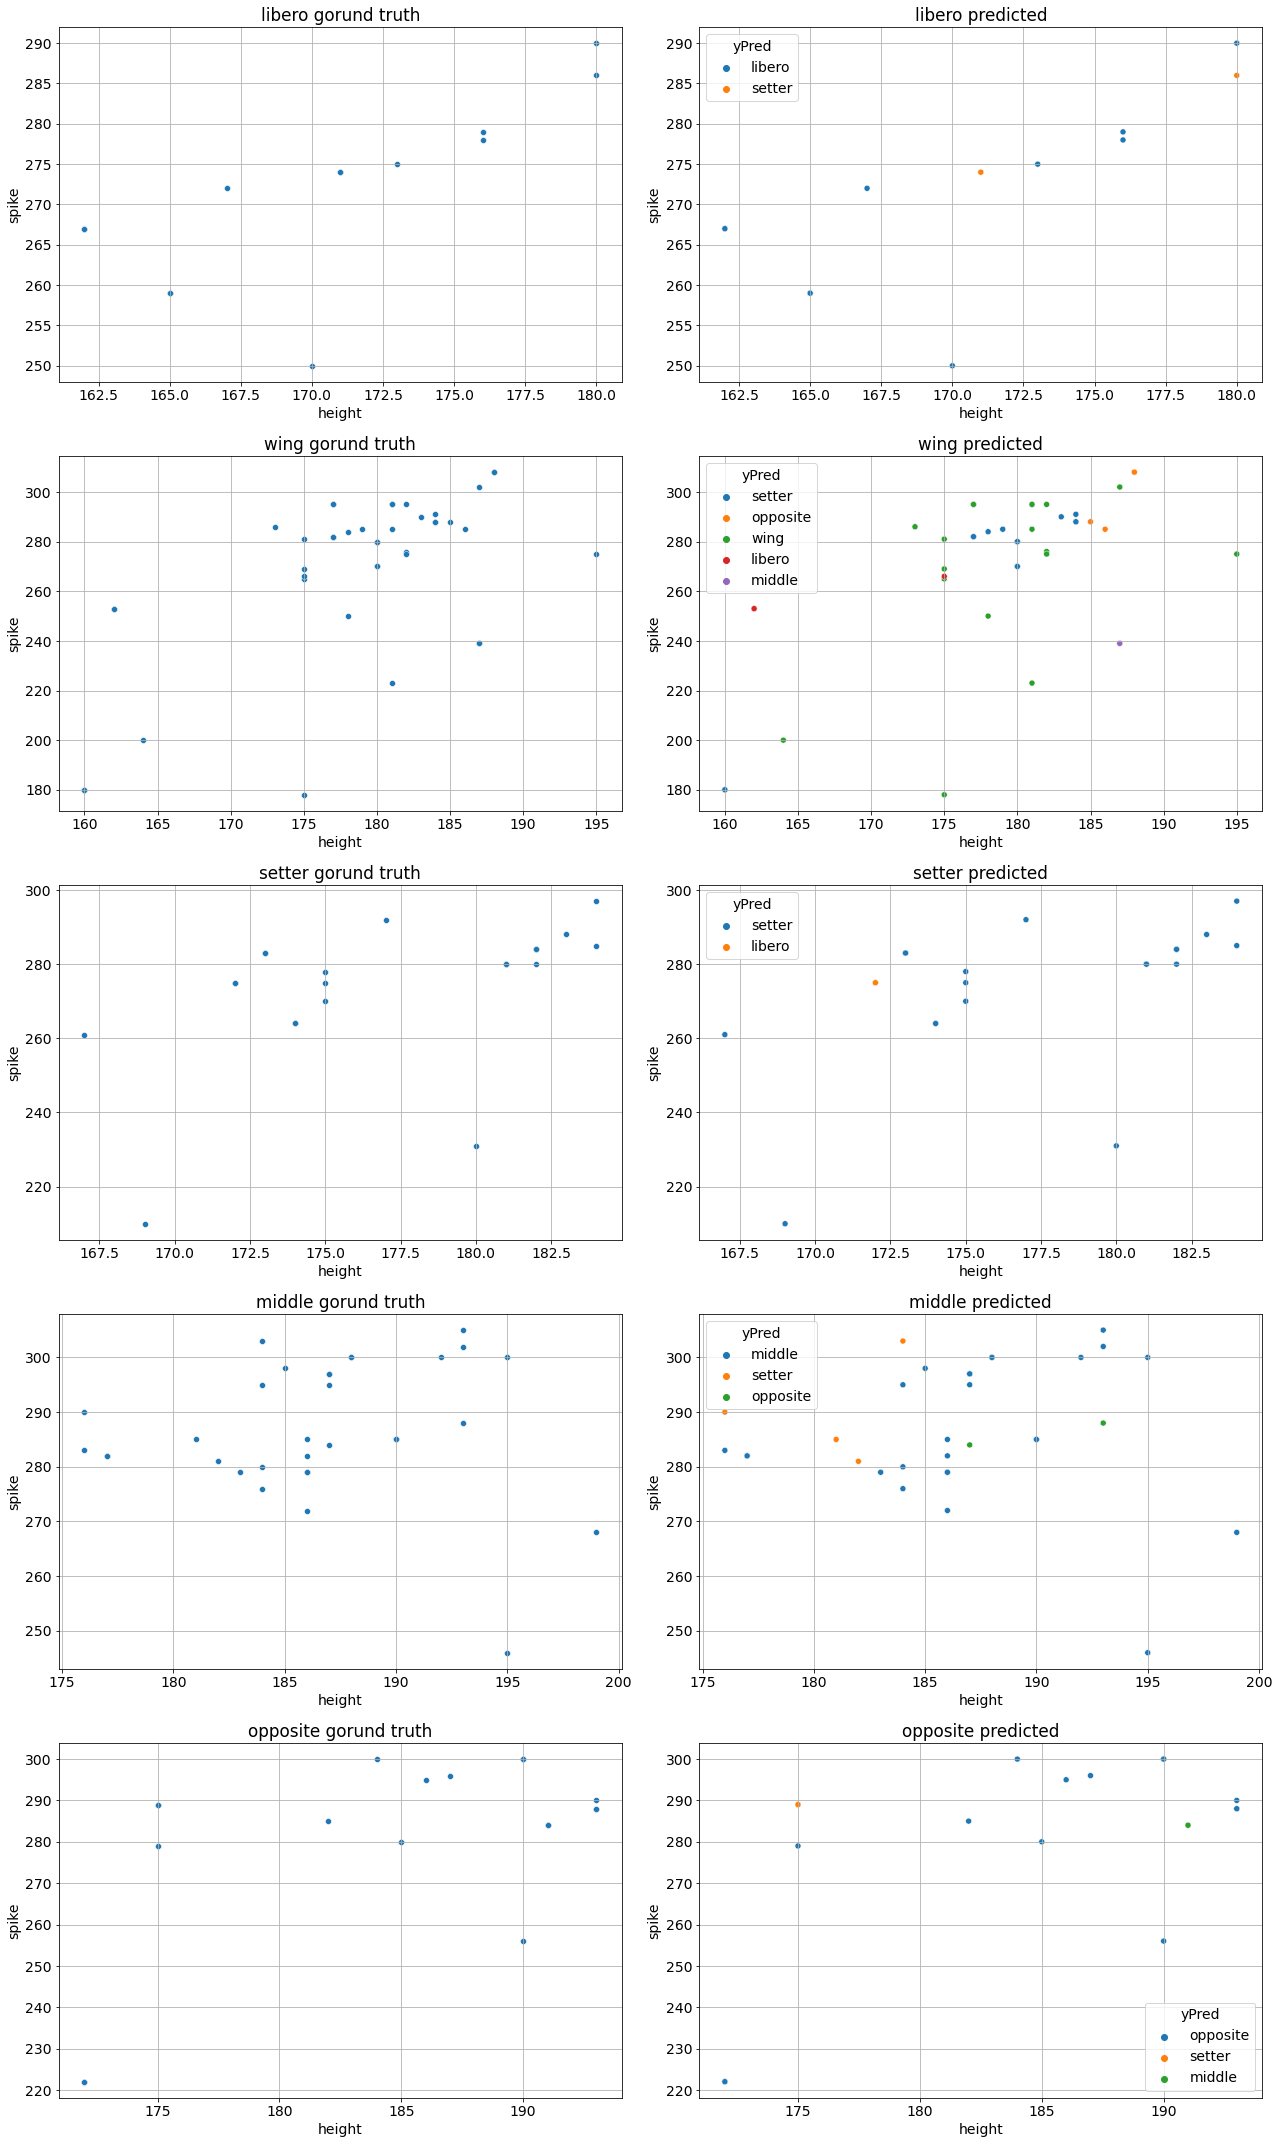

In [37]:
plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(figsize = (18,30), ncols = 2, nrows = 5)

labels = results['yTest'].unique()

for count, label in enumerate(labels):
    plotClassPoints(results, label, axs[count][0], axs[count][1])
    
fig.tight_layout()

All in all, in terms of accuracy, we can see that the liberos, setters and opposites are the easiest classes to predict, while wing players are often mistaken for some other positions. This makes sense up to an extent: Wing players must be versatile, they have to be good at spiking and blocking, but have to be agile to defend too. This versatility is probably reflected in their physical characteristics.  
Middle blockers must be the tallest possible, so we would expect to be the easiest to classify. However, this model does a mediocre job at it.